In [1]:
%load_ext autoreload
%autoreload 2

import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import axcgnss as axg


# Load files

In [2]:
# Load results 
folder_path = './.results/'
df_results = pd.DataFrame()
for file in os.listdir(folder_path):
    if file.endswith(".pkl"):
        with open(os.path.join(folder_path, file), 'rb') as handle:
            _results = pickle.load(handle)
        _results = pd.DataFrame(_results)
        df_results = pd.concat([df_results, _results])

In [3]:
# # This cell is just to test the re-generation capacity based on saved seed

# from simulations import worker

# param = all_results.iloc[0]

# # Generate PRN code
# correlator_delays = range(-200, 201, 1)
# signal_prn = axg.GenerateGPSGoldCode(prn=param['prn'])
# signal = axg.UpsampleCode(signal_prn, param['sampling_frequency'])
# # Generate the replicas
# replicas = axg.GenerateDelayedReplicas(signal, correlator_delays)

# results = worker(param['run'], param['prn'], signal, replicas, 200, 1, param['cn0_target_dB'], param['sampling_frequency'], 
#        param['quantization'], axg.EAL_MULTIPLIERS_8BIT_SIGNED, seed=param['seed'])


## Analysis of a specific correlation

In [4]:
axc_mult = 'mul8s_1L12'
cn0 = 35
bits = 8
freq = 2*axg.GPS_L1CA_CODE_FREQ


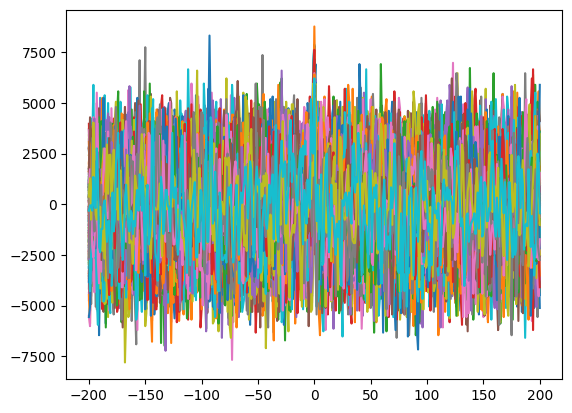

In [5]:
df = axg.select_data(df_results, freq, bits, cn0)
axg.plotSimulation(df, axc_mult)

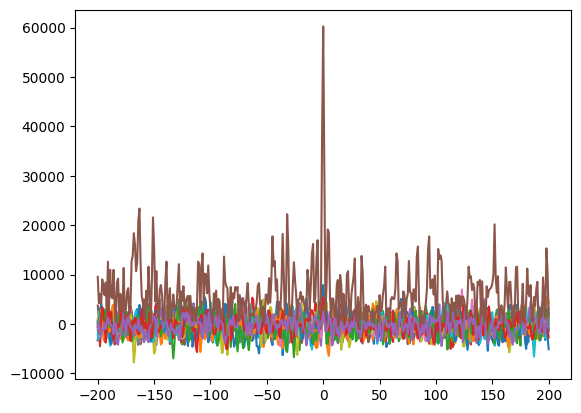

In [6]:
df = axg.select_data(df_results, freq, bits, cn0)
axg.plotCoherentCorrelation(df, axc_mult, 15)

## Analysis of the post correlation SNR

In [7]:
cn0_range = range(30, 55, 5)

(0.0, 25.0)

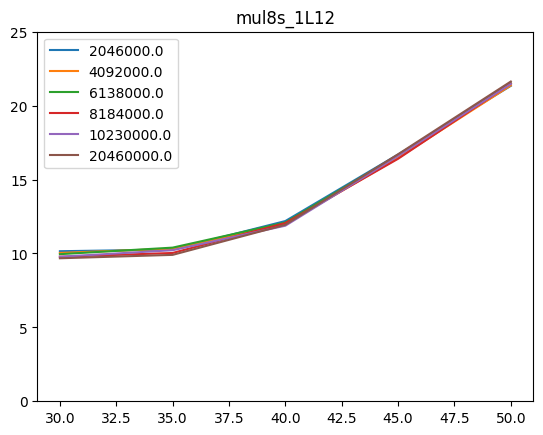

In [18]:
axg.plotPostCorrelationSNRPerFrequency(df_results, 'mul8s_1L12', cn0_range, np.array([2,4,6,8,10,20]) * axg.GPS_L1CA_CODE_FREQ, 8)
plt.ylim(0, 25)

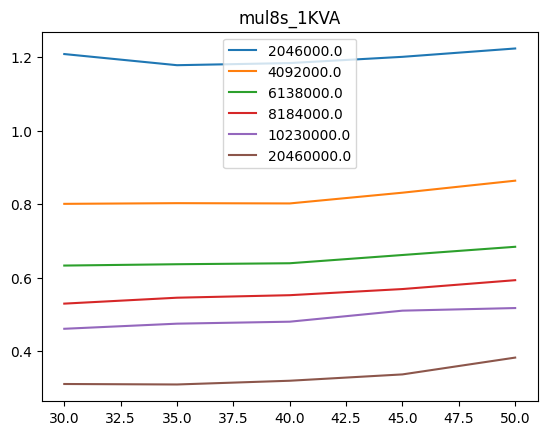

In [20]:
axg.plotPostCorrelationSNRPerFrequency(df_results, 'mul8s_1KVA', cn0_range, np.array([2,4,6,8,10,20]) * axg.GPS_L1CA_CODE_FREQ, 8)
#plt.ylim(0, 25)

/mnt/d/Projects/Navigation/MyCode/axcgnss/Simulations/axcgnss.py:305: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(value_linear)
/mnt/d/Projects/Navigation/MyCode/axcgnss/Simulations/axcgnss.py:305: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(value_linear)
/mnt/d/Projects/Navigation/MyCode/axcgnss/Simulations/axcgnss.py:305: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(value_linear)


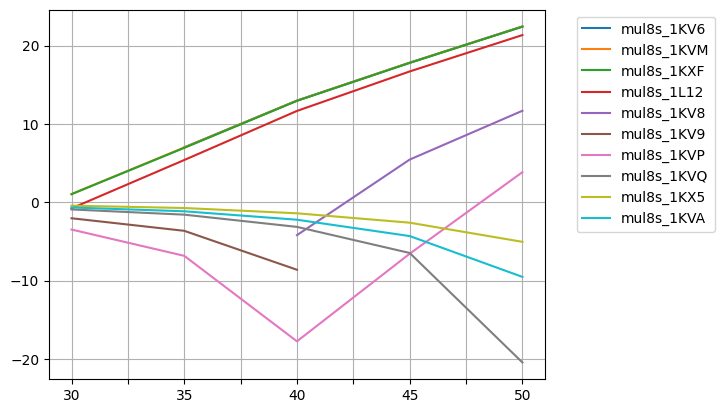

In [12]:
axg.plotPostCorrelationSNRPerAxC(df_results, cn0_range, 2 * axg.GPS_L1CA_CODE_FREQ, 8)

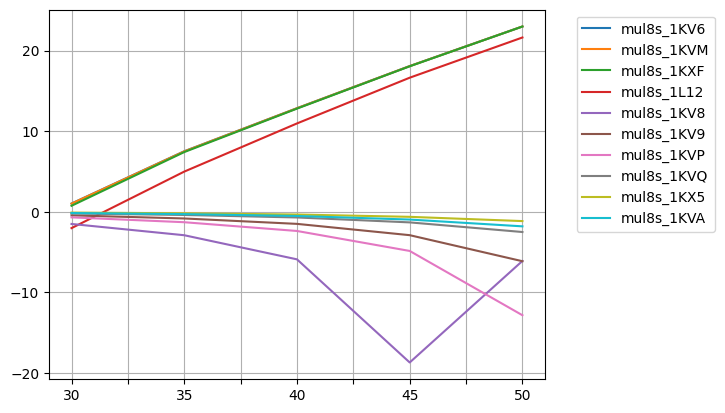

In [13]:
axg.plotPostCorrelationSNRPerAxC(df_results, cn0_range, 20 * axg.GPS_L1CA_CODE_FREQ, 8)

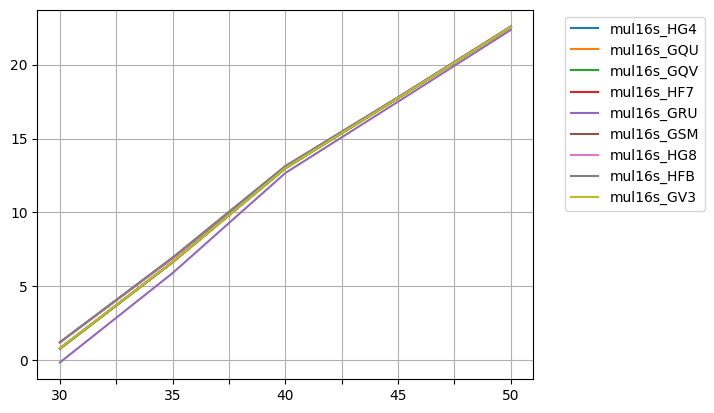

In [14]:
axg.plotPostCorrelationSNRPerAxC(df_results, cn0_range, 2 * axg.GPS_L1CA_CODE_FREQ, 16)

/mnt/d/Projects/Navigation/MyCode/axcgnss/Simulations/axcgnss.py:305: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(value_linear)


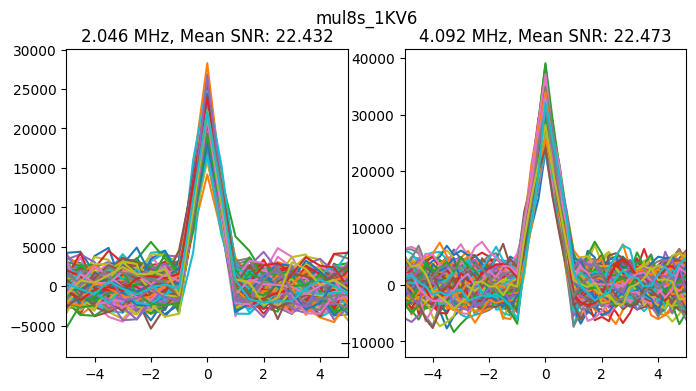

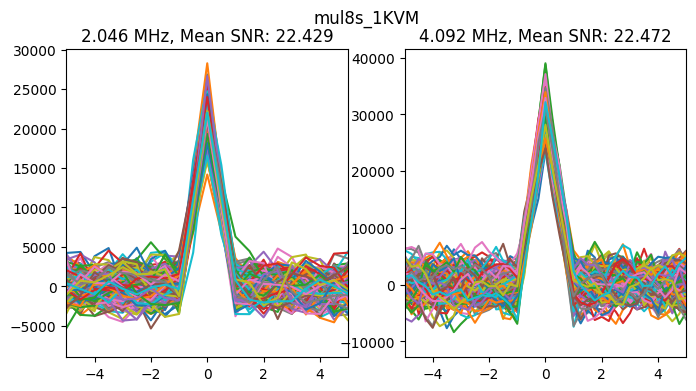

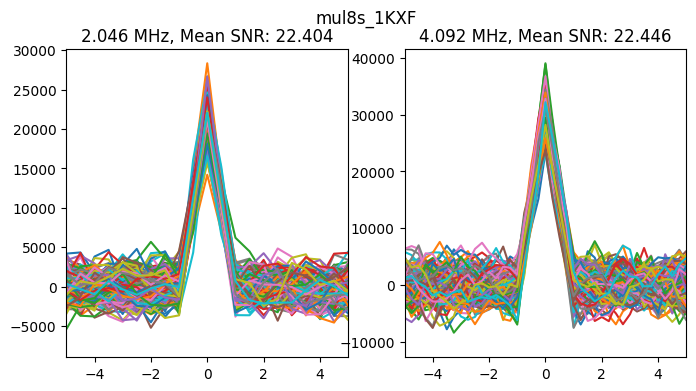

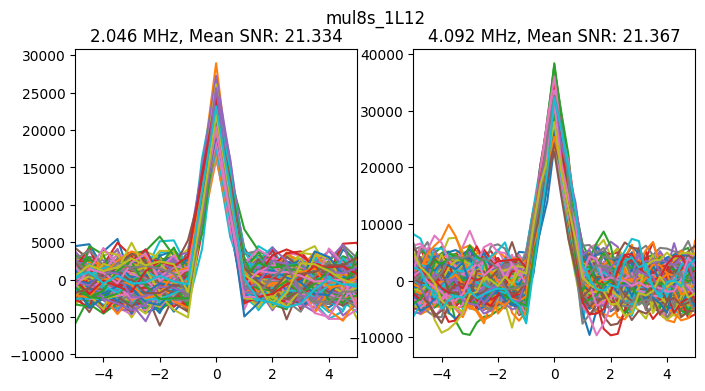

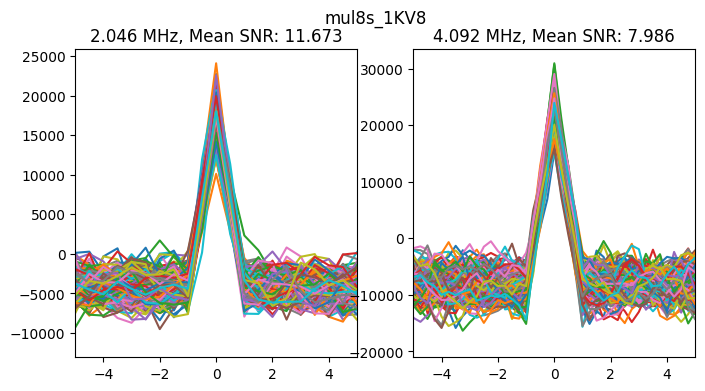

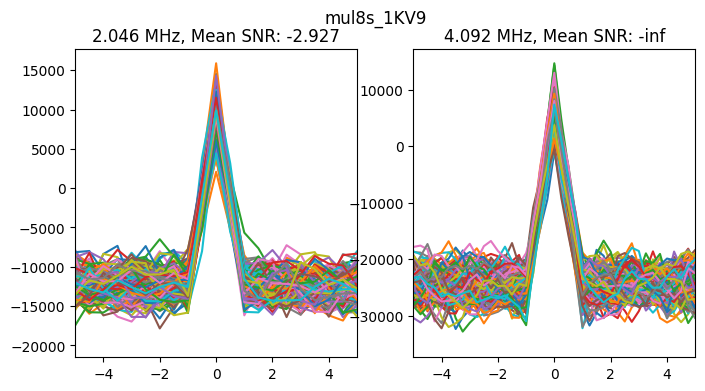

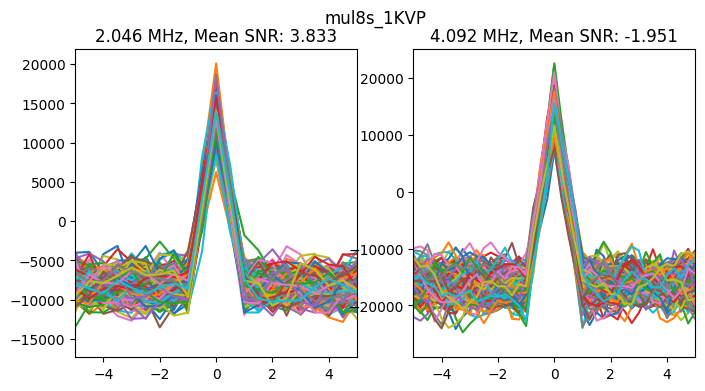

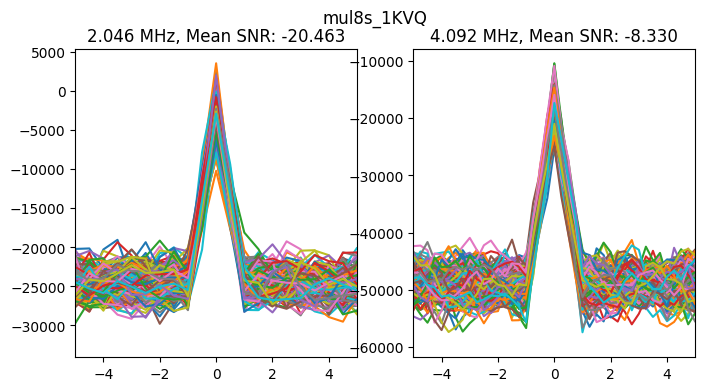

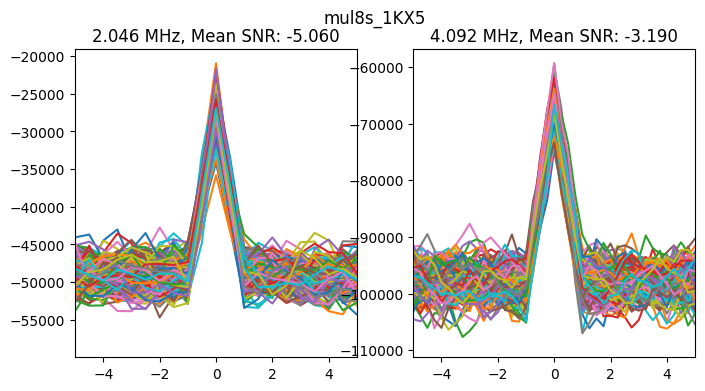

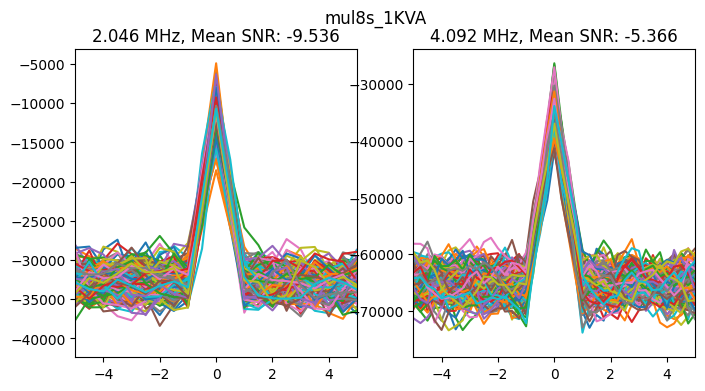

In [15]:
axc_mult_list = list(axg.EAL_MULTIPLIERS_8BIT_SIGNED.keys())
sf_list = np.array([2, 4]) * axg.GPS_L1CA_CODE_FREQ
cn0 = 50

for axc_mult in axc_mult_list:
    fig, axs = plt.subplots(1,2, figsize=(8, 4), facecolor='w', edgecolor='k')
    fig.suptitle(axc_mult)
    i = 0
    for sf in sf_list:
        samplesPerChip = round(sf / axg.GPS_L1CA_CODE_FREQ)
        df = axg.select_data(df_results, sf, 8, cn0)
        snr = []
        for index, row in df.iterrows():
            # corr = np.abs(row[f'axc_corr_{axc_mult}'])
            corr = row[f'axc_corr_{axc_mult}']
            corr_lags = np.arange(-row['delay_range'], row['delay_range']+1, row['delay_step'])
            axs[i].plot(corr_lags/samplesPerChip, corr)
            snr.append(axg.getPostCorrelationSNR(corr, sf, idxPeak=200))
        snr = np.array(snr)
        axs[i].set_xlim((-5,5))
        axs[i].set_title(f"{sf/1e6:.3f} MHz, Mean SNR: {snr.mean():.3f}")
        i += 1
    